# 🔍 Comparing Vector Retrieval Methods: Dense, Sparse, and Hybrid with Qdrant

This notebook demonstrates how to use **LangChain + Qdrant** to retrieve documents using three different techniques:

- **Dense Retrieval**: Semantic search using embeddings (e.g. Sentence Transformers)
- **Sparse Retrieval**: Lexical-based keyword search (like BM25)
- **Hybrid Retrieval**: Combines both for better results

And an extra bonus:
- **MMR retrieval** uses Maximal Marginal Relevance to re-rank results, ensuring a diverse set of documents by reducing redundancy.


We’ll explore how they differ in results and overlap, and visualize how much they agree on relevant documents.

> 🔧 Prerequisites: A running Qdrant instance with documents already indexed.

In [1]:
import matplotlib.pyplot as plt
import pandas as pd
from langchain_huggingface import HuggingFaceEmbeddings
from langchain_qdrant import FastEmbedSparse, QdrantVectorStore, RetrievalMode

from sp_rag import settings

In [2]:
# Qdrant configuration
URL = "http://localhost:6333"
COLLECTION_NAME = "arxiv_papers"
EMBEDDINGS = HuggingFaceEmbeddings(model_name=settings.DENSE_EMBEDDING_MODEL)
SPARSE_EMBEDDINGS = FastEmbedSparse(model_name=settings.SPARSE_EMBEDDING_MODEL)

In [3]:
# Define the query and parameters for the retrieval
query = "deep learning for natural language processing"
K = 10
SEARCH_TYPE = "similarity"
SEARCH_KWARGS = {
    "k": K,
}

In [4]:
# Dense-only
dense_vs = QdrantVectorStore.from_existing_collection(
    url=URL,
    collection_name=COLLECTION_NAME,
    embedding=EMBEDDINGS,
    sparse_embedding=SPARSE_EMBEDDINGS,
    sparse_vector_name="sparse_vector",
    retrieval_mode=RetrievalMode.DENSE,
)
dense_retriever = dense_vs.as_retriever(
    search_type=SEARCH_TYPE, search_kwargs=SEARCH_KWARGS
)
dense_results = dense_retriever.invoke(query)

# Sparse-only
sparse_vs = QdrantVectorStore.from_existing_collection(
    url=URL,
    collection_name=COLLECTION_NAME,
    embedding=EMBEDDINGS,
    sparse_embedding=SPARSE_EMBEDDINGS,
    sparse_vector_name="sparse_vector",
    retrieval_mode=RetrievalMode.SPARSE,
)
sparse_retriever = sparse_vs.as_retriever(
    search_type=SEARCH_TYPE, search_kwargs=SEARCH_KWARGS
)
sparse_results = sparse_retriever.invoke(query)

# Hybrid
hybrid_vs = QdrantVectorStore.from_existing_collection(
    url=URL,
    collection_name=COLLECTION_NAME,
    embedding=EMBEDDINGS,
    sparse_embedding=SPARSE_EMBEDDINGS,
    sparse_vector_name="sparse_vector",
    retrieval_mode=RetrievalMode.HYBRID,
)
hybrid_retriever = hybrid_vs.as_retriever(
    search_type=SEARCH_TYPE, search_kwargs=SEARCH_KWARGS
)

hybrid_results = hybrid_retriever.invoke(query)

# MMR
mmr_retriever = dense_vs.as_retriever(
    search_type="mmr",
    search_kwargs={
        "k": K,
        "fetch_k": K * 2,
        'lambda_mult': 0.25
    },
)

mmr_results = mmr_retriever.invoke(query)

In [5]:
def extract_titles(results):
    return [doc.metadata.get("title", "Untitled") for doc in results]

pd.DataFrame(
    {
        "Dense-Only": extract_titles(dense_results),
        "Sparse-Only": extract_titles(sparse_results),
        "Hybrid": extract_titles(hybrid_results),
        "MMR": extract_titles(mmr_results),
    }
).head(15)

,Dense-Only,Sparse-Only,Hybrid,MMR
0,Text Change Detection in Multilingual Document...,Efficiently Integrate Large Language Models wi...,Efficiently Integrate Large Language Models wi...,Text Change Detection in Multilingual Document...
1,Using Images to Find Context-Independent Word ...,Towards Zero-Shot & Explainable Video Descript...,Text Change Detection in Multilingual Document...,Do better language models have crisper vision?
2,Augmenting Multimodal LLMs with Self-Reflectiv...,Parameter Competition Balancing for Model Merging,Using Images to Find Context-Independent Word ...,Efficiently Integrate Large Language Models wi...
3,Movie2Story: A framework for understanding vid...,Positive-Augmented Contrastive Learning for Vi...,Towards Zero-Shot & Explainable Video Descript...,M3DocRAG: Multi-modal Retrieval is What You Ne...
4,LLaVA-Mini: Efficient Image and Video Large Mu...,Preserving Pre-trained Representation Space: O...,Augmenting Multimodal LLMs with Self-Reflectiv...,MetaMetrics: Calibrating Metrics For Generatio...
5,M3DocRAG: Multi-modal Retrieval is What You Ne...,Differentiable Prompt Learning for Vision Lang...,Parameter Competition Balancing for Model Merging,JanusFlow: Harmonizing Autoregression and Rect...
6,Efficiently Integrate Large Language Models wi...,Alignment Between the Decision-Making Logic of...,Movie2Story: A framework for understanding vid...,Using Images to Find Context-Independent Word ...
7,Layerwise Change of Knowledge in Neural Networks,Parameter Competition Balancing for Model Merging,Positive-Augmented Contrastive Learning for Vi...,LLaVA-Mini: Efficient Image and Video Large Mu...
8,MMSearch: Benchmarking the Potential of Large ...,Sparse Attention Vectors: Generative Multimoda...,Preserving Pre-trained Representation Space: O...,PDF-WuKong: A Large Multimodal Model for Effic...
9,VideoEspresso: A Large-Scale Chain-of-Thought ...,Differentiable Prompt Learning for Vision Lang...,LLaVA-Mini: Efficient Image and Video Large Mu...,Layerwise Change of Knowledge in Neural Networks


In [6]:
def get_ids(results):
    return set(doc.metadata.get("paper_id") for doc in results)

dense_ids = get_ids(dense_results)
sparse_ids = get_ids(sparse_results)
hybrid_ids = get_ids(hybrid_results)
mmr_ids = get_ids(mmr_results)
print(len(sparse_ids), len(dense_ids), len(hybrid_ids), len(mmr_ids))

8 10 10 10


/home/sasce/PycharmProjects/ScientificPapersRAG/.venv/lib/python3.11/site-packages/upsetplot/data.py:385: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df.fillna(False, inplace=True)
/home/sasce/PycharmProjects/ScientificPapersRAG/.venv/lib/python3.11/site-packages/upsetplot/plotting.py:795: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace o

<Figure size 1000x600 with 0 Axes>

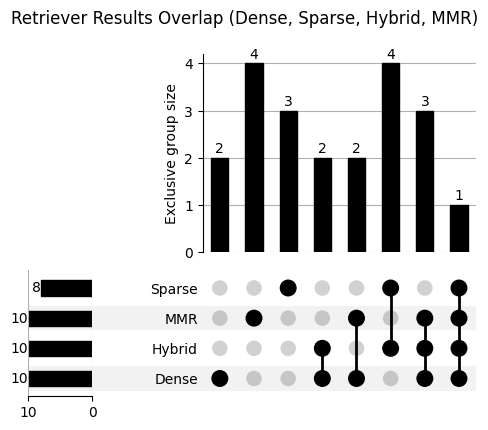

In [7]:
from upsetplot import UpSet, from_contents

contents = {
    "Dense": dense_ids,
    "Sparse": sparse_ids,
    "Hybrid": hybrid_ids,
    "MMR": mmr_ids,
}
upset_data = from_contents(contents)

plt.figure(figsize=(10, 6))
UpSet(upset_data, subset_size="count", show_counts=True).plot()
plt.suptitle("Retriever Results Overlap (Dense, Sparse, Hybrid, MMR)")
plt.ylabel("Exclusive group size")
plt.show()

In [8]:
def rank_positions(documents):
    return {doc.metadata["paper_id"]: i + 1 for i, doc in enumerate(documents)}


# Get rank maps
hybrid_ranks = rank_positions(hybrid_results)
dense_ranks = rank_positions(dense_results)
sparse_ranks = rank_positions(sparse_results)
mmr_ranks = rank_positions(mmr_results)

# Compare rank positions for overlapping papers
overlap_ids = hybrid_ids & dense_ids & sparse_ids & mmr_ids

data = []
for paper_id in overlap_ids:
    data.append(
        {
            "Paper ID": paper_id,
            "Hybrid Rank": hybrid_ranks[paper_id],
            "Dense Rank": dense_ranks[paper_id],
            "Sparse Rank": sparse_ranks[paper_id],
            "MMR Rank": mmr_ranks[paper_id],
        }
    )

pd.DataFrame(data)

,Paper ID,Hybrid Rank,Dense Rank,Sparse Rank,MMR Rank
0,2502.01524v1,1,7,1,3


# ✅ Summary

- **Dense retrieval** is great for semantic similarity but might miss keyword matches.
- **Sparse retrieval** is good for exact keyword search but can miss semantically related content.
- **Hybrid retrieval** offers the best of both — combining lexical + semantic.

Extra:
- **MMR retrieval** uses Maximal Marginal Relevance to re-rank results, ensuring a diverse set of documents by reducing redundancy.

We visualized how the methods overlap and even compared their **ranking positions** for overlapping documents.